In [43]:
import tensorflow as tf
#from tensorflow.contrib import rnn
import random
import collections
import time
import numpy as np
#!pip install xgboost
!pip install keras
!pip install -U -q PyDrive ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
 




You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Saving combine.csv to combine (1).csv
User uploaded file "combine.csv" with length 1344292 bytes


In [0]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import itertools
import io
#import xgboost
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
import sklearn
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
encoding=LabelEncoder()
from keras.models import Sequential
from keras.layers import Input
from keras.models import Model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM, SimpleRNN,GRU
from keras.optimizers import RMSprop
%matplotlib inline

In [0]:
#Uploading the data
json_import = drive.CreateFile({'id':'15uCD0KVYK4WlUGqGbsXxLtHQ9MXr-9Vx'})
json_import.GetContentFile('combine.csv')
data_set=pd.read_csv('combine.csv')
data_set.fillna(0, inplace=True)

In [0]:
columns_req = ['HomeTeam','AwayTeam','FTHG','FTAG','FTR','HS','AS',
               'HST','AST','HF','AF','HC','AC','HY','AY','HR','AR']

playing_stat = data_set[columns_req]
playing_stat=playing_stat[0:6740]

In [0]:
#Storing Each of the events
HomeTeam=playing_stat.HomeTeam
encoding.fit(HomeTeam.values)
HomeTeam=encoding.transform(HomeTeam.values)
AwayTeam=playing_stat.AwayTeam
AwayTeam=encoding.transform(AwayTeam.values)
X_teams=np.vstack([HomeTeam,AwayTeam]).T
FTHG=playing_stat.FTHG
FTHG=FTHG.values.reshape(-1,1)
FTHG=FTHG.astype(np.int64)
FTAG=playing_stat.FTAG
FTAG=FTAG.values.reshape(-1,1)
FTAG=FTAG.astype(np.int64)
HS=playing_stat.HS
HS=HS.values.reshape(-1,1)
HS=HS.astype(np.int64)
AS=playing_stat.AS
AS=AS.values.reshape(-1,1)
AS=AS.astype(np.int64)
HST=playing_stat.HST
HST=HST.values.reshape(-1,1)
HST=HST.astype(np.int64)
AST=playing_stat.AST
AST=AST.values.reshape(-1,1)
AST=AST.astype(np.int64)
HF=playing_stat.HF
HF=HF.values.reshape(-1,1)
HF=HS.astype(np.int64)
AF=playing_stat.AF
AF=AF.values.reshape(-1,1)
AF=AF.astype(np.int64)
HC=playing_stat.HC
HC=HC.values.reshape(-1,1)
HC=HC.astype(np.int64)
HY=playing_stat.HY
HY=HY.values.reshape(-1,1)
HY=HY.astype(np.int64)
AY=playing_stat.AY
AY=AY.values.reshape(-1,1)
AY=AY.astype(np.int64)
HR=playing_stat.HR
HR=HR.values.reshape(-1,1)
HR=HR.astype(np.int64)
AR=playing_stat.AR
AR=AR.values.reshape(-1,1)
AR=AR.astype(np.int64)
Y=playing_stat.FTR
encoding.fit(Y.values)
Y=encoding.transform(Y.values)
Y=Y.reshape(-1,1)

In [79]:
onehot=OneHotEncoder()
X_teams=onehot.fit_transform(X_teams).todense()
FTHG=onehot.fit_transform(FTHG).todense()
FTAG=onehot.fit_transform(FTAG).todense()
HS=onehot.fit_transform(HS).todense()
AS=onehot.fit_transform(AS).todense()
HST=onehot.fit_transform(HST).todense()
AST=onehot.fit_transform(AST).todense()
HF=onehot.fit_transform(HF).todense()
AF=onehot.fit_transform(AF).todense()
HC=onehot.fit_transform(HC).todense()
HY=onehot.fit_transform(HY).todense()
AY=onehot.fit_transform(AY).todense()
HR=onehot.fit_transform(HR).todense()
AR=onehot.fit_transform(AR).todense()
Y=onehot.fit_transform(Y).todense()
encoded_x=np.concatenate((X_teams,FTHG,FTAG,HS,AS,HST,AST,HF,AF,HC,HY,AY,HR,AR),axis=1)
print(encoded_x.shape)

(6740, 360)


In [0]:
#Splitting the test and training data randomly
seed=7
X_train, X_test, y_train, y_test = train_test_split(encoded_x, Y, test_size=0.1, random_state=seed)
#Use np.array so as to reshape
X_train=np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

In [0]:
#In order to change the shape according to the time steps
def shape(X,Y,time_steps):
    n_x,n_y=[],[]
    #Takes the first 1 to time_steps in sequence
    for i in range (0,len(X)-time_steps+1):
        x_int=X[i:i+time_steps,:].reshape((time_steps,X.shape[1]))
        y_int=Y[i+time_steps-1,:]
        n_x.append(x_int)
        n_y.append(y_int)
        
    return np.array(n_x),np.array(n_y)

In [82]:
time_steps=5
#Reshape has data,time_steps,features
#Only reshape input data
X_train,y_train=shape(X_train,y_train,time_steps)
X_test,y_test=shape(X_test,y_test,time_steps)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(6062, 5, 360) (6062, 3) (670, 5, 360) (670, 3)


In [0]:
time_steps=5
input_dimensions=360
#Shape=time_steps,one_hot_vector_size
inputs=Input(shape=(time_steps,input_dimensions))
X1=LSTM(32,return_sequences=True)(inputs)
#Dropping the temporal dimension by not giving return_sequences=True....So that the past 5 matches can be used to predict the next game result
X1=LSTM(32)(X1)
#Softmax layer for output(The number of neurons is the number of classes)
output=Dense(3,activation='softmax')(X1)
#Creating the model
model=Model(inputs=inputs,outputs=output)


In [35]:
#To get summary of model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 5, 360)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 5, 32)             50304     
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 58,723
Trainable params: 58,723
Non-trainable params: 0
_________________________________________________________________


In [12]:
#Defining the model for rmsprop
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
#Validation_split for using it in validation data
history=model.fit(X_train,y_train,batch_size=64,epochs=7,validation_split=0.33)

Train on 4061 samples, validate on 2001 samples
Epoch 1/7
4061/4061 [==============================] - 2s 561us/step - loss: 1.0552 - acc: 0.4600 - val_loss: 1.0340 - val_acc: 0.4743
Epoch 2/7
4061/4061 [==============================] - 1s 350us/step - loss: 0.9806 - acc: 0.5201 - val_loss: 0.8611 - val_acc: 0.6282
Epoch 3/7
4061/4061 [==============================] - 1s 352us/step - loss: 0.6835 - acc: 0.7257 - val_loss: 0.5450 - val_acc: 0.7711
Epoch 4/7
4061/4061 [==============================] - 1s 337us/step - loss: 0.4458 - acc: 0.8646 - val_loss: 0.4015 - val_acc: 0.8596
Epoch 5/7
4061/4061 [==============================] - 1s 335us/step - loss: 0.3023 - acc: 0.9384 - val_loss: 0.2713 - val_acc: 0.9460
Epoch 6/7
4061/4061 [==============================] - 1s 336us/step - loss: 0.2070 - acc: 0.9677 - val_loss: 0.2269 - val_acc: 0.9355
Epoch 7/7
4061/4061 [==============================] - 1s 342us/step - loss: 0.1402 - acc: 0.9801 - val_loss: 0.1528 - val_acc: 0.9630


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


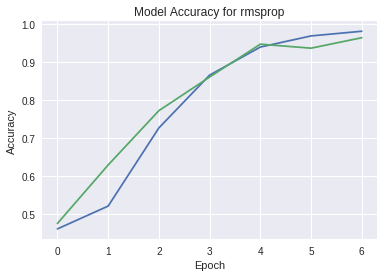

In [13]:
#To get the colmn names
print(history.history.keys())
#To plot the accuracies for rmsprop
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy for rmsprop')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

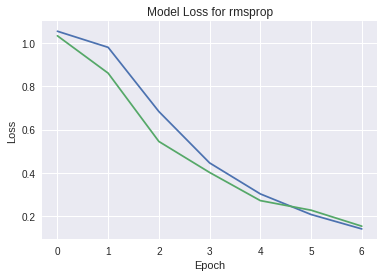

In [14]:
#To plot the loss for rmsprop
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss for rmsprop')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [26]:
#Defining the model for sgd
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])
#Validation_split for using it in validation data
history=model.fit(X_train,y_train,batch_size=64,epochs=7,validation_split=0.33)

Train on 4061 samples, validate on 2001 samples
Epoch 1/7
4061/4061 [==============================] - 2s 490us/step - loss: 1.0854 - acc: 0.4361 - val_loss: 1.0735 - val_acc: 0.4728
Epoch 2/7
4061/4061 [==============================] - 1s 312us/step - loss: 1.0691 - acc: 0.4649 - val_loss: 1.0632 - val_acc: 0.4728
Epoch 3/7
4061/4061 [==============================] - 1s 326us/step - loss: 1.0637 - acc: 0.4649 - val_loss: 1.0598 - val_acc: 0.4728
Epoch 4/7
4061/4061 [==============================] - 1s 328us/step - loss: 1.0619 - acc: 0.4649 - val_loss: 1.0584 - val_acc: 0.4728
Epoch 5/7
4061/4061 [==============================] - 1s 328us/step - loss: 1.0613 - acc: 0.4649 - val_loss: 1.0578 - val_acc: 0.4728
Epoch 6/7
4061/4061 [==============================] - 1s 329us/step - loss: 1.0609 - acc: 0.4649 - val_loss: 1.0575 - val_acc: 0.4728
Epoch 7/7
4061/4061 [==============================] - 1s 340us/step - loss: 1.0607 - acc: 0.4649 - val_loss: 1.0573 - val_acc: 0.4728


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


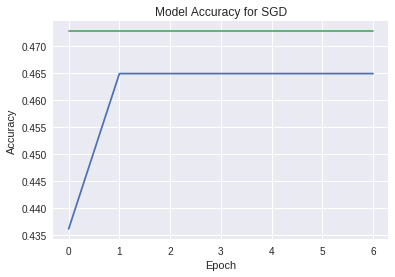

In [27]:
#To get the colmn names
print(history.history.keys())
#To plot the accuracies for sgd
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy for SGD')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

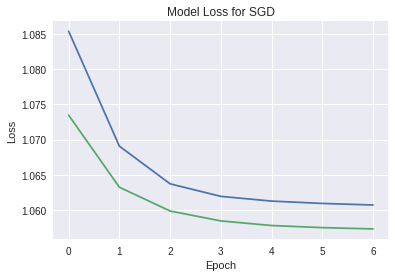

In [28]:
#To plot the Losses for SGD
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss for SGD')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [36]:
#Defining the model for ADAM
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#Validation_split for using it in validation data
history=model.fit(X_train,y_train,batch_size=64,epochs=7,validation_split=0.33)

Train on 4061 samples, validate on 2001 samples
Epoch 1/7
4061/4061 [==============================] - 3s 685us/step - loss: 1.0606 - acc: 0.4595 - val_loss: 1.0425 - val_acc: 0.4728
Epoch 2/7
4061/4061 [==============================] - 1s 360us/step - loss: 1.0080 - acc: 0.4871 - val_loss: 0.9326 - val_acc: 0.6077
Epoch 3/7
4061/4061 [==============================] - 1s 344us/step - loss: 0.6515 - acc: 0.7338 - val_loss: 0.4523 - val_acc: 0.8666
Epoch 4/7
4061/4061 [==============================] - 1s 359us/step - loss: 0.3338 - acc: 0.9197 - val_loss: 0.2774 - val_acc: 0.9385
Epoch 5/7
4061/4061 [==============================] - 1s 343us/step - loss: 0.1947 - acc: 0.9749 - val_loss: 0.1773 - val_acc: 0.9705
Epoch 6/7
4061/4061 [==============================] - 1s 341us/step - loss: 0.1192 - acc: 0.9884 - val_loss: 0.1286 - val_acc: 0.9740
Epoch 7/7
4061/4061 [==============================] - 1s 347us/step - loss: 0.0767 - acc: 0.9938 - val_loss: 0.0956 - val_acc: 0.9805


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


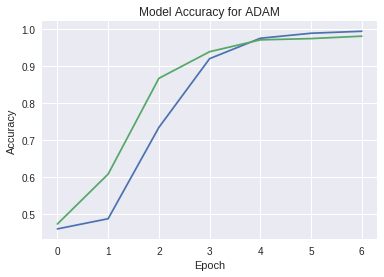

In [37]:
#To get the colmn names
print(history.history.keys())
#To plot the accuracies for ADAM
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy for ADAM')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

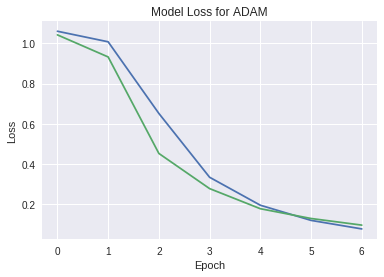

In [38]:
#To plot the Losses for ADAM
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss for ADAM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [39]:
scores,acc=model.evaluate(X_test,y_test,batch_size=64)
print(acc)

670/670 [==============================] - 0s 105us/step
0.9835820895522388


In [0]:
#Implementing using GRU
time_steps=5
input_dimensions=360
#Shape=time_steps,one_hot_vector_size
inputs=Input(shape=(time_steps,input_dimensions))
X1=GRU(32,return_sequences=True)(inputs)
#Dropping the temporal dimension by not giving return_sequences=True....So that the past 5 matches can be used to predict the next game result
X1=GRU(32)(X1)
#Softmax layer for output(The number of neurons is the number of classes)
output=Dense(3,activation='softmax')(X1)
#Creating the model
model=Model(inputs=inputs,outputs=output)


In [84]:
#To get summary of model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 5, 360)            0         
_________________________________________________________________
gru_5 (GRU)                  (None, 5, 32)             37728     
_________________________________________________________________
gru_6 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 99        
Total params: 44,067
Trainable params: 44,067
Non-trainable params: 0
_________________________________________________________________


In [85]:
#Defining the model for ADAM
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#Validation_split for using it in validation data
history=model.fit(X_train,y_train,batch_size=64,epochs=7,validation_split=0.33)

Train on 4061 samples, validate on 2001 samples
Epoch 1/7
4061/4061 [==============================] - 3s 763us/step - loss: 1.0247 - acc: 0.4787 - val_loss: 0.9538 - val_acc: 0.5772
Epoch 2/7
4061/4061 [==============================] - 1s 293us/step - loss: 0.7291 - acc: 0.6949 - val_loss: 0.4725 - val_acc: 0.8381
Epoch 3/7
4061/4061 [==============================] - 1s 358us/step - loss: 0.3298 - acc: 0.9266 - val_loss: 0.2272 - val_acc: 0.9555
Epoch 4/7
4061/4061 [==============================] - 1s 291us/step - loss: 0.1610 - acc: 0.9778 - val_loss: 0.1334 - val_acc: 0.9760
Epoch 5/7
4061/4061 [==============================] - 1s 290us/step - loss: 0.0885 - acc: 0.9911 - val_loss: 0.0823 - val_acc: 0.9860
Epoch 6/7
4061/4061 [==============================] - 1s 297us/step - loss: 0.0527 - acc: 0.9956 - val_loss: 0.0636 - val_acc: 0.9890
Epoch 7/7
4061/4061 [==============================] - 1s 297us/step - loss: 0.0328 - acc: 0.9973 - val_loss: 0.0504 - val_acc: 0.9885


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


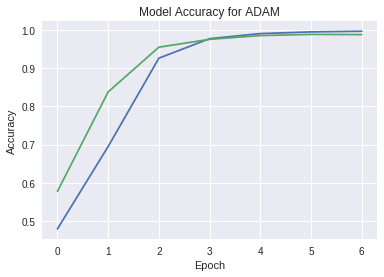

In [86]:
#To get the colmn names
print(history.history.keys())
#To plot the accuracies for GRU ADAM
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy for ADAM')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

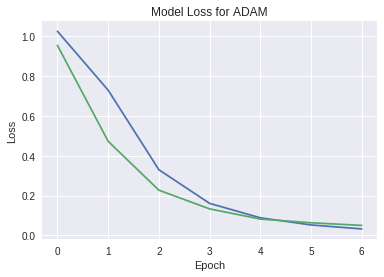

In [87]:
#To plot the Losses for ADAM GRU
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss for ADAM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()